# 📊 HR Analytics Project: Employee Productivity and Retention

In this project, we analyze employee productivity, satisfaction, and attrition using HR data from two office branches. We’ll merge, clean, and explore the dataset to uncover insights about:
- Top departments by work hours
- Trends in employee promotions and resignations
- Key metrics impacting employee retention

### Step 1: Load Data Directly from URLs

In [9]:
import pandas as pd
import requests #Allows us to send HTTP requests in Python (used to fetch files from the web).
from io import BytesIO # Lets us treat bytes as a file object (needed for reading raw web data into pandas).

# Define data URLs
urls = {
    'A_office': 'https://www.dropbox.com/s/jpeknyzx57c4jb2/A_office_data.xml?dl=1',
    'B_office': 'https://www.dropbox.com/s/hea0tbhir64u9t5/B_office_data.xml?dl=1',
    'HR': 'https://www.dropbox.com/s/u6jzqqg1byajy0s/hr_data.xml?dl=1'
}

# Load each dataset directly from the web
a_df = pd.read_xml(BytesIO(requests.get(urls['A_office']).content))
b_df = pd.read_xml(BytesIO(requests.get(urls['B_office']).content))
hr_df = pd.read_xml(BytesIO(requests.get(urls['HR']).content))

# Check shapes to confirm successful load
print("A_office shape:", a_df.shape)
print("B_office shape:", b_df.shape)
print("HR_data shape:", hr_df.shape)


A_office shape: (3019, 8)
B_office shape: (5981, 8)
HR_data shape: (10000, 4)


### 🔍 Data Preview and Structure

Before cleaning, here’s what each dataset looks like:

---

#### 🏢 `A_office` and `B_office` DataFrame

| Column Name             | Description |
|-------------------------|-------------|
| `number_project`        | Number of projects worked on |
| `average_monthly_hours`| Monthly average hours worked |
| `time_spend_company`    | Tenure in years |
| `Work_accident`         | 1 = had accident, 0 = no accident |
| `promotion_last_5years`| 1 = promoted, 0 = not promoted |
| `Department`            | Employee department (e.g., sales) |
| `salary`                | Salary tier (low, medium, etc.) |
| `employee_office_id`    | Office-specific numeric employee ID |


#### 👥 `HR` DataFrame

| Column Name         | Description |
|---------------------|-------------|
| `satisfaction_level`| How satisfied the employee was |
| `last_evaluation`   | Most recent performance evaluation score |
| `left`              | 1 = employee left the company |
| `employee_id`       | Employee ID (already prefixed with "A" or "B") — used as index for merging |




In [10]:
print("A_office DataFrame:")
print(a_df.head())

print("\nB_office DataFrame:")
print(b_df.head())

print("\nHR DataFrame:")
print(hr_df.head())


A_office DataFrame:
   number_project  average_monthly_hours  time_spend_company  Work_accident  \
0               5                    262                   6              0   
1               5                    223                   5              0   
2               2                    153                   3              0   
3               6                    247                   4              0   
4               5                    224                   5              0   

   promotion_last_5years Department  salary  employee_office_id  
0                      0      sales  medium                   2  
1                      0      sales     low                   4  
2                      0      sales     low                   6  
3                      0      sales     low                   7  
4                      0      sales     low                   9  

B_office DataFrame:
   number_project  average_monthly_hours  time_spend_company  Work_accident  \
0        

### Step 2: Clean and Reindex the Data

In this step, we:

- Prefixed each `employee_office_id` with `"A"` or `"B"` to distinguish between employees from different office locations.
- Set the `employee_id` column as the index for the HR dataset to align it with the office data for merging.
- Checked for missing values and verified the data types across the three datasets using `.info()`.

These preparations ensure all datasets are properly structured and ready for merging in the next step.


In [11]:
# Reindex a_df and b_df by prefixing employee_office_id
a_df.index = ['A' + str(i) for i in a_df['employee_office_id']]
b_df.index = ['B' + str(i) for i in b_df['employee_office_id']]

# Set hr_df index to employee_id
hr_df.set_index('employee_id', inplace=True)

# Check the new indexes
print("Sample a_df index:", a_df.index[:3].tolist())
print("Sample b_df index:", b_df.index[:3].tolist())
print("Sample hr_df index:", hr_df.index[:3].tolist())

# Check for nulls
print("\nMissing values per column in a_df:\n", a_df.isnull().sum())
print("\nMissing values per column in b_df:\n", b_df.isnull().sum())
print("\nMissing values per column in hr_df:\n", hr_df.isnull().sum())

# Quick datatype check
print("\na_df dtypes:\n", a_df.dtypes)
print("\nb_df dtypes:\n", b_df.dtypes)
print("\nhr_df dtypes:\n", hr_df.dtypes)


Sample a_df index: ['A2', 'A4', 'A6']
Sample b_df index: ['B1', 'B3', 'B5']
Sample hr_df index: ['A1', 'A3', 'A4']

Missing values per column in a_df:
 number_project           0
average_monthly_hours    0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
Department               0
salary                   0
employee_office_id       0
dtype: int64

Missing values per column in b_df:
 number_project           0
average_monthly_hours    0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
Department               0
salary                   0
employee_office_id       0
dtype: int64

Missing values per column in hr_df:
 satisfaction_level    0
last_evaluation       0
left                  0
dtype: int64

a_df dtypes:
 number_project            int64
average_monthly_hours     int64
time_spend_company        int64
Work_accident             int64
promotion_last_5years     int64
Department               object
salary                 

### Step 3: Merge and Clean Combined Data

In this step, we:

- **Concatenated** the A and B office datasets into a single DataFrame.
- **Merged** this combined office dataset with the HR dataset using their aligned employee IDs as indices.
- **Filtered** the result to include only employees present in both office and HR data using the `_merge` indicator.
- **Dropped** redundant columns like `employee_office_id` and `_merge` after ensuring alignment.
- **Sorted** the final DataFrame by index for easier navigation and cleaner analysis.

The resulting dataset is a unified and clean view of employee attributes, performance, and HR metrics — ready for analysis.


In [12]:
# Combine A and B office data
office_df = pd.concat([a_df, b_df])

# Merge with HR data on index
merged_df = office_df.merge(hr_df, left_index=True, right_index=True, how='left', indicator=True)

# Keep only rows that exist in both datasets
merged_df = merged_df[merged_df['_merge'] == 'both']

# Drop redundant columns
merged_df.drop(columns=['employee_office_id', '_merge'], inplace=True)

# Sort by index
merged_df.sort_index(inplace=True)

# Check the structure
print("Merged data shape:", merged_df.shape)
print("Sample columns:", merged_df.columns.tolist())
print("Sample index:", merged_df.index[:5].tolist())


Merged data shape: (5982, 10)
Sample columns: ['number_project', 'average_monthly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'Department', 'salary', 'satisfaction_level', 'last_evaluation', 'left']
Sample index: ['A10', 'A100', 'A1002', 'A1003', 'A1006']


### Step 4: Answer Exploratory Questions

We extracted insights from the merged dataset:

- **Top 10 Departments by Average Monthly Hours:** We identified the departments with the highest workloads to understand which areas may be overburdened.
- **Total Number of Projects for Low-Salary IT Employees:** This metric gives insight into whether lower-compensated employees in technical departments are carrying heavier workloads.
- **Evaluation and Satisfaction Levels for Selected Employees:** By looking up specific employee IDs, we examined their performance and satisfaction scores for closer inspection.

These answers give us a snapshot of potential overwork, pay disparity, and individual performance.


In [13]:
# Question 1: Top 10 departments by average monthly hours
top10_departments = (
    merged_df.sort_values(by='average_monthly_hours', ascending=False)['Department']
    .head(10)
    .tolist()
)

# Question 2: Total number of projects for low-salary IT employees
low_salary_it_projects = (
    merged_df[(merged_df['Department'] == 'IT') & (merged_df['salary'] == 'low')]['number_project']
    .sum()
)

# Question 3: Evaluation and satisfaction for specific employees
employees_info = (
    merged_df.loc[['A4', 'B7064', 'A3033'], ['last_evaluation', 'satisfaction_level']]
    .values
    .tolist()
)

# Output the answers
print("Top 10 Departments by Monthly Hours:", top10_departments)
print("Total Projects (low-salary IT employees):", low_salary_it_projects)
print("Selected Employees' [Evaluation, Satisfaction]:", employees_info)


Top 10 Departments by Monthly Hours: ['support', 'marketing', 'technical', 'hr', 'support', 'sales', 'hr', 'support', 'technical', 'technical']
Total Projects (low-salary IT employees): 847
Selected Employees' [Evaluation, Satisfaction]: [[0.87, 0.72], [0.56, 0.36], [0.94, 0.93]]


### Step 5: Aggregate the Data by Employee Exit Status

In this step, we grouped employees based on whether they **left the company** (`left = 1`) or **are still employed** (`left = 0`) and calculated:

- **Median number of projects**, and how many employees had more than 5 projects.
- **Mean and median tenure** at the company.
- **Average accident rate**.
- **Mean and standard deviation** of evaluation scores.

These aggregations help us understand patterns related to attrition, including workload, performance, and tenure trends across current and former employees.


In [14]:
#Define custom aggregation function
def count_bigger_5(series):
    return (series > 5).sum()

# Group by whether the employee left the company
grouped = merged_df.groupby('left').agg({
    'number_project': ['median', count_bigger_5],
    'time_spend_company': ['mean', 'median'],
    'Work_accident': ['mean'],
    'last_evaluation': ['mean', 'std']
})

# Round all numeric results
grouped = grouped.round(2)

#Display as dictionary
grouped_dict = grouped.to_dict()
print(grouped_dict)


{('number_project', 'median'): {0.0: 4.0, 1.0: 4.0}, ('number_project', 'count_bigger_5'): {0.0: 207, 1.0: 339}, ('time_spend_company', 'mean'): {0.0: 3.4, 1.0: 3.91}, ('time_spend_company', 'median'): {0.0: 3.0, 1.0: 4.0}, ('Work_accident', 'mean'): {0.0: 0.18, 1.0: 0.04}, ('last_evaluation', 'mean'): {0.0: 0.72, 1.0: 0.72}, ('last_evaluation', 'std'): {0.0: 0.16, 1.0: 0.2}}


### Step 6: Generate and Filter Pivot Tables

We created two pivot tables to derive high-level insights for the HR department:

#### Pivot Table 1:
- **Rows:** `Department`
- **Columns:** `left` (employment status) and `salary`
- **Values:** Median of `average_monthly_hours`

Filtered to show only departments where:
- **Current employees:** High-salary median hours < Medium-salary median hours.
- - We ask: Are high-paid employees being given easier workloads than medium-paid ones?

- **Former employees:** Low-salary median hours < High-salary median hours.
- - We ask: Were low-paid employees working as hard or harder than high-paid ones — but still not compensated fairly?


#### Pivot Table 2:
- **Rows:** `time_spend_company`
- **Columns:** `promotion_last_5years`
- **Values:** Min, Max, and Mean of `satisfaction_level` and `last_evaluation`

Filtered to include only rows where the **mean evaluation score** is **higher** for employees **without promotion** than those with promotion.
- 🔍 We ask: Are high-performing employees being overlooked for promotion?
- 🔍 We ask: Does lack of recognition contribute to disengagement or turnover?

These summaries provide valuable strategic insights into employee workload and performance trends across departments and tenure levels.


In [26]:
# Pivot Table 1
pivot1 = merged_df.pivot_table(
    index='Department',
    columns=['left', 'salary'],
    values='average_monthly_hours',
    aggfunc='median'
).round(2)

# Filter departments
filtered_pivot1 = pivot1[
    (pivot1.get((0.0, 'high'), 0) < pivot1.get((0.0, 'medium'), 0)) |
    (pivot1.get((1.0, 'low'), 0) < pivot1.get((1.0, 'high'), 0))
]

# Pivot Table 2
pivot2 = merged_df.pivot_table(
    index='time_spend_company',
    columns='promotion_last_5years',
    values=['satisfaction_level', 'last_evaluation'],
    aggfunc=['min', 'max', 'mean']
).round(2)

# Filter for time_spend_company rows where unpromoted employees had higher mean last_evaluation
filtered_pivot2 = pivot2[
    pivot2[('mean', 'last_evaluation', 0)] > pivot2[('mean', 'last_evaluation', 1)]
]

# Display both
display(filtered_pivot1)
display(filtered_pivot2)



left           0.0                  1.0              
salary        high    low medium   high    low medium
Department                                           
IT           193.0  198.5  199.0  155.0  235.0  198.0
management   196.0  208.0  201.0  259.0  230.5  235.0
marketing    173.0  199.5  185.0  148.5  155.0  157.0
product_mng  172.0  198.5  202.0  149.0  218.0  154.5
sales        190.0  198.0  198.0  241.5  224.5  225.0
support      214.0  194.5  196.0  237.0  219.0  221.0
technical    193.0  197.0  202.0  157.5  244.0  232.0

min                                 \
                      last_evaluation       satisfaction_level         
promotion_last_5years               0     1                  0     1   
time_spend_company                                                     
2                                0.37  0.52               0.09  0.29   
4                                0.36  0.42               0.09  0.15   
5                                0.38  0.37               0.09  0.23   
6                                0.37  0.38               0.12  0.48   
10                               0.37  0.48               0.14  0.22   

                                  max                                 \
                      last_evaluation       satisfaction_level         
promotion_last_5years               0     1                  0     1   
time_spend_company                                                     
2                                 1.0  0.99               1.00  0.94   
4                                 1.0  0.90               1.00  0.94   
5                                 1.0  0.91               1.00  0.82   
6                                 1.0  0.71               1.00  0.81   
10                                1.0  0.94               0.99  0.85   

                                 mean                                 
                      last_evaluation       satisfaction_level        
promotion_last_5years               0     1                  0     1  
time_spend_company                                                    
2                                0.72  0.69               0.70  0.65  
4                                0.77  0.75               0.48  0.60  
5                                0.82  0.61               0.62  0.66  
6                                0.77  0.52               0.59  0.62  
10                               0.72  0.63               0.66  0.51

### Step 7.1: Top 10 Employees by Average Monthly Hours

In this step, we visualize the top 10 employees who have the highest average monthly working hours. This helps us identify potential overworked individuals or key contributors.

We also include their department to understand whether any particular unit tends to have high work hours.


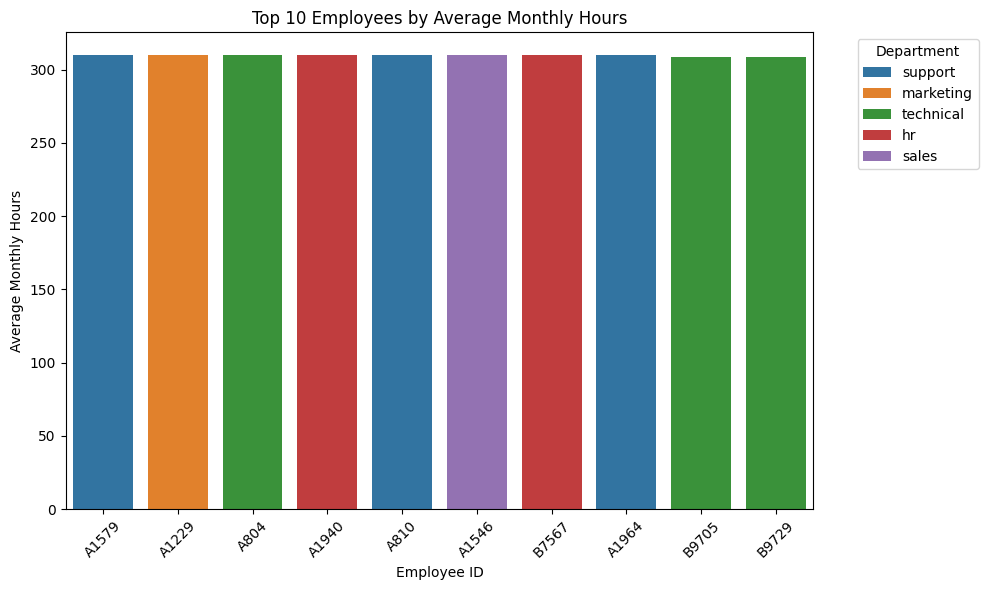

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 10 employees by monthly working hours
top_employees = merged_df.sort_values(by='average_monthly_hours', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_employees.index,
    y=top_employees['average_monthly_hours'],
    hue=top_employees['Department'],
    dodge=False
)

plt.title('Top 10 Employees by Average Monthly Hours')
plt.xlabel('Employee ID')
plt.ylabel('Average Monthly Hours')
plt.xticks(rotation=45)
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### 🧠 Key Observations:
- All 10 employees are working **over 310 hours per month**, well above typical workload levels — a potential sign of **overwork or burnout risk**.
- These employees span multiple departments, including:
  - **Support**
  - **Technical**
  - **HR**
  - **Sales**
  - **Marketing**
- Certain departments (e.g., **Support** and **Technical**) appear more than once, suggesting that these units may have **systemic workload issues**.

#### 📌 Implications for HR:
- These individuals may require immediate support, recognition, or workload redistribution.
- Departments with repeated representation should be reviewed for **staffing adequacy** or **workflow optimization**.
- This analysis helps prioritize follow-up conversations and policy adjustments related to **employee well-being** and **retention strategy**.

### Step 7.2: Project Distribution Among IT Employees by Salary Tier

This bar chart visualizes how the number of projects varies across different salary levels for employees in the IT department.

It helps highlight whether lower-salaried employees are overburdened with projects, which could inform workload balancing and compensation policies.


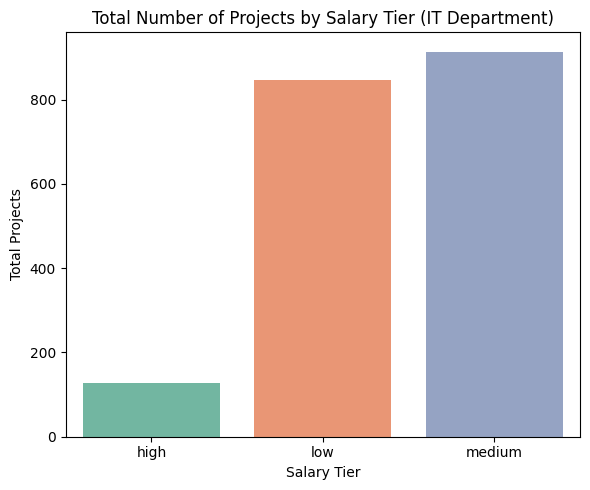

In [17]:
# Filter IT department data
it_df = merged_df[merged_df['Department'] == 'IT']

# Group by salary and sum the number of projects
projects_by_salary = it_df.groupby('salary')['number_project'].sum().sort_index()

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(
    x=projects_by_salary.index,
    y=projects_by_salary.values,
    palette='Set2'
)

plt.title('Total Number of Projects by Salary Tier (IT Department)')
plt.xlabel('Salary Tier')
plt.ylabel('Total Projects')
plt.tight_layout()
plt.show()


#### 🧠 Key Observations:
- **Low-salary and medium-salary employees** are handling the bulk of the project load.
- **High-salary employees** are assigned **significantly fewer projects** despite their compensation level.

#### 📌 Implications for HR and Management:
- This suggests a potential **workload imbalance** within the IT department.
- **Lower-tier employees** may be **overburdened**, which could lead to:
  - Decreased satisfaction
  - Burnout
  - Increased risk of attrition
- Meanwhile, **higher-paid employees may be underutilized**, signaling an opportunity to **redistribute tasks** or reassess team structure.

This visualization supports a deeper review of workload equity and may help guide future **compensation, staffing, and task allocation** decisions within IT.

### Step 7.3: Performance Snapshot for Selected Employees

This chart highlights the **last evaluation scores** and **satisfaction levels** of three specific employees:

- A4
- B7064
- A3033

These employees were manually selected for closer inspection. Comparing both metrics side-by-side helps assess whether high evaluation scores align with satisfaction.


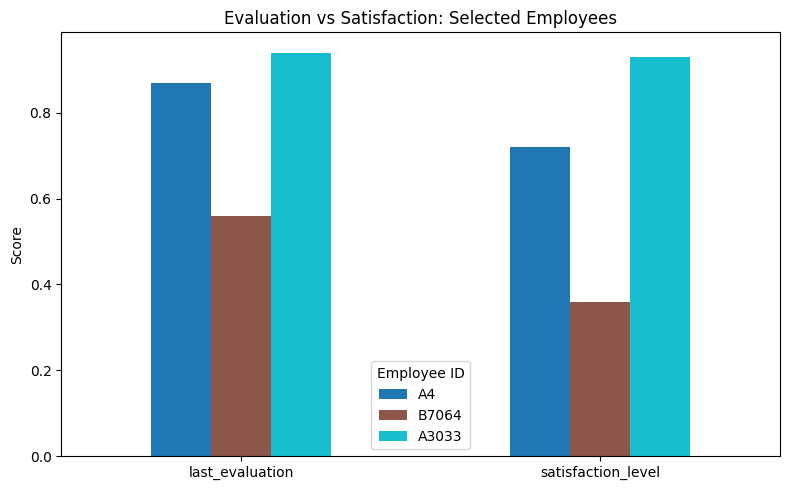

In [18]:
# Extract data
selected_ids = ['A4', 'B7064', 'A3033']
selected_df = merged_df.loc[selected_ids, ['last_evaluation', 'satisfaction_level']]

# Transpose for easier side-by-side plotting
selected_df_transposed = selected_df.T

# Plot
selected_df_transposed.plot(
    kind='bar',
    figsize=(8, 5),
    colormap='tab10',
    rot=0
)

plt.title('Evaluation vs Satisfaction: Selected Employees')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Employee ID')
plt.tight_layout()
plt.show()


#### 🧠 Key Observations:
- **A3033** has **high evaluation and satisfaction**, indicating strong alignment between performance and morale.
- **A4** shows a **high evaluation score** but a **lower satisfaction level**, which could signal a high-performing employee at risk of disengagement.
- **B7064** exhibits both **low evaluation and very low satisfaction**, which may suggest underperformance, burnout, or a poor fit.

#### 📌 Implications for HR:
- These individual profiles help HR identify:
  - High performers who may need recognition or advancement (A4)
  - At-risk employees requiring support or intervention (B7064)
- Comparing evaluation vs. satisfaction helps assess whether **strong contributors feel valued and supported** — a key factor for retention.

This targeted view is useful for employee-specific check-ins and aligning performance management with engagement strategies.

### Step 8: Aggregated Summary – Retained vs Resigned Employees

To assist HR in identifying trends related to employee attrition, we group employees based on their status (`left = 0` for current employees, `left = 1` for those who left).

We compute:
- Median number of projects
- Count of employees working on more than 5 projects
- Mean and median time spent at the company
- Share of employees with work accidents
- Mean and standard deviation of last evaluation scores

This summary offers a compact overview of key differences between the two groups.


In [19]:
# Custom function to count employees with >5 projects
def count_bigger_5(series):
    return (series > 5).sum()

# Aggregated metrics by 'left' status
agg_df = merged_df.groupby('left').agg({
    'number_project': ['median', count_bigger_5],
    'time_spend_company': ['mean', 'median'],
    'Work_accident': ['mean'],
    'last_evaluation': ['mean', 'std']
})

# Round and display
agg_df = agg_df.round(2)
display(agg_df)


number_project                time_spend_company        Work_accident  \
             median count_bigger_5               mean median          mean   
left                                                                         
0.0             4.0            207               3.40    3.0          0.18   
1.0             4.0            339               3.91    4.0          0.04   

     last_evaluation        
                mean   std  
left                        
0.0             0.72  0.16  
1.0             0.72  0.20

#### 🧠 Key Observations:

| Metric                          | Stayed (`left=0`) | Left (`left=1`) | Insight |
|--------------------------------|-------------------|-----------------|---------|
| Median Projects                | 4                 | 4               | No difference in typical workload size |
| Count with >5 Projects         | 207               | 339             | **More leavers were overloaded** |
| Avg. Time at Company (Years)   | 3.40              | 3.91            | Slightly longer tenure before leaving |
| Work Accident Rate             | 18%               | 4%              | Accidents are more common among those who stayed |
| Avg. Evaluation Score          | 0.72              | 0.72            | No difference in average performance |
| Evaluation Score Variability   | 0.16              | 0.20            | More inconsistent evaluations for those who left |

---

#### 📌 Implications for HR:
- **Overwork appears to be a key attrition driver**: 339 employees who left had >5 projects.
- **Evaluation inconsistency** (higher standard deviation) may erode trust or satisfaction.
- **Work accidents are not clearly linked to leaving**, but may indicate risk areas in operations.

This aggregated summary equips HR to proactively investigate workload distribution, fairness in performance feedback, and support systems to retain top talent.


### Step 9: Final Visualizations & Business Insights

To wrap up the project, we create clear, stakeholder-friendly visualizations for our key findings. These plots summarize patterns in workload, performance, satisfaction, and retention.

We'll focus on:
- Departmental workload vs. salary tiers
- Evaluation vs. satisfaction comparisons by promotion status
- Employee churn indicators


### 9.1 Median Monthly Hours by Salary Tier (Current Employees)

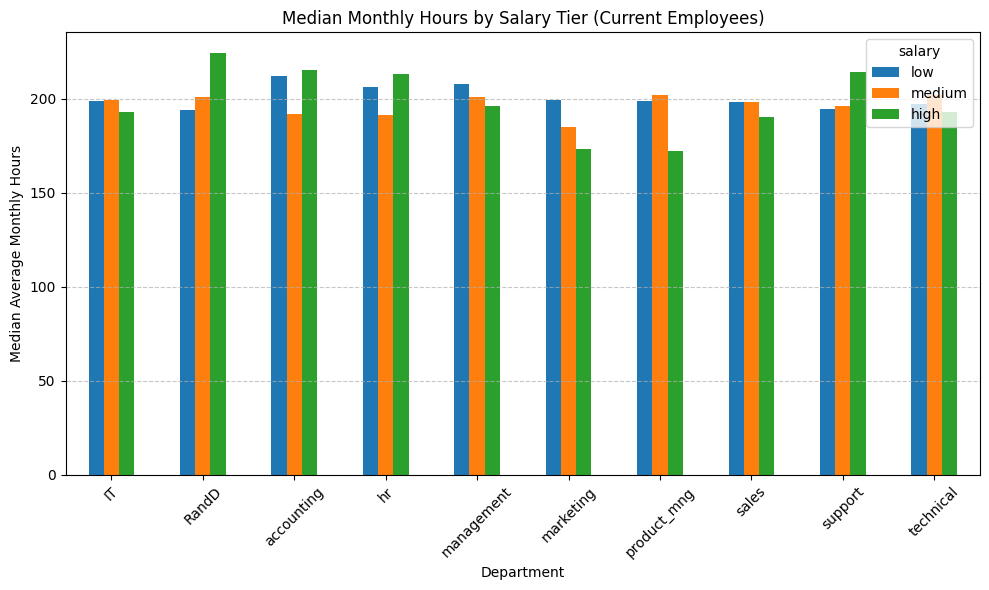

In [21]:
import matplotlib.pyplot as plt

# Extract current employees
current = merged_df[merged_df['left'] == 0]

# Pivot for plotting
dept_hours = current.pivot_table(
    index='Department',
    columns='salary',
    values='average_monthly_hours',
    aggfunc='median'
).reindex(columns=['low', 'medium', 'high'])  # for consistent order

# Plot
dept_hours.plot(kind='bar', figsize=(10,6), title="Median Monthly Hours by Salary Tier (Current Employees)")
plt.ylabel("Median Average Monthly Hours")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### 🧠 Key Observations:
- In several departments (e.g., **accounting**, **support**, **technical**), **low- or medium-salary employees** appear to work **more hours** than high-salary employees.
- The **R&D department** stands out for high-salary employees working the **most hours**, which may suggest higher responsibility or performance-based roles there.
- In contrast, in departments like **marketing** and **product management**, high-salary employees tend to have **lower workloads**, which may prompt workload reassessment.

#### 📌 Implications for HR:
- Uneven workload distribution could indicate:
  - **Undercompensated overwork** among lower-tier employees
  - **Inefficient task allocation** or role design for high earners in some teams
- This visualization supports more **equitable task assignment** and can inform compensation and retention strategies by department.


### 9.2 Mean Satisfaction & Evaluation by Promotion Status


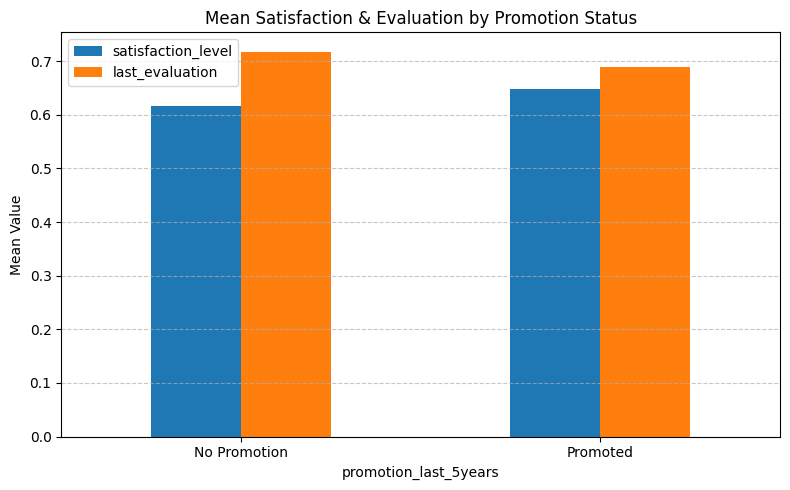

In [22]:
# Group by promotion status
promo_perf = merged_df.groupby('promotion_last_5years')[['satisfaction_level', 'last_evaluation']].mean()

# Plot
promo_perf.plot(kind='bar', figsize=(8,5), title="Mean Satisfaction & Evaluation by Promotion Status")
plt.ylabel("Mean Value")
plt.xticks(ticks=[0,1], labels=["No Promotion", "Promoted"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### 🧠 Key Observations:
- Employees **without a promotion** reported **slightly higher evaluation scores** than those who were promoted.
- Interestingly, **satisfaction is also marginally lower** among non-promoted employees — indicating that strong performance doesn't always equate to morale.
- Promoted employees show **moderate satisfaction and evaluation**, which may suggest a more stable but not necessarily peak-performing group.

#### 📌 Implications for HR:
- High-performing, non-promoted individuals may be **overlooked** or **undervalued**, potentially driving dissatisfaction or attrition.
- Promotions may not always go to top evaluators — a sign to review performance-recognition alignment.
- A transparent, merit-based advancement policy could help improve both satisfaction and retention among strong contributors.

This visualization reinforces the earlier pivot analysis and highlights the **performance–promotion disconnect**.

### 9.3 Attrition Risk Heatmap

To identify where attrition is most concentrated, we computed the **attrition rate** across departments and salary tiers.

- The heatmap shows the proportion of employees who have left (`left == 1`) relative to all employees within each `(Department, Salary)` combination.
- Higher values indicate higher turnover risk within that group.
- Notably, **low-salary employees in management, marketing, and support** departments exhibit **some of the highest attrition rates**.

This analysis helps HR target retention strategies where they’re most needed.


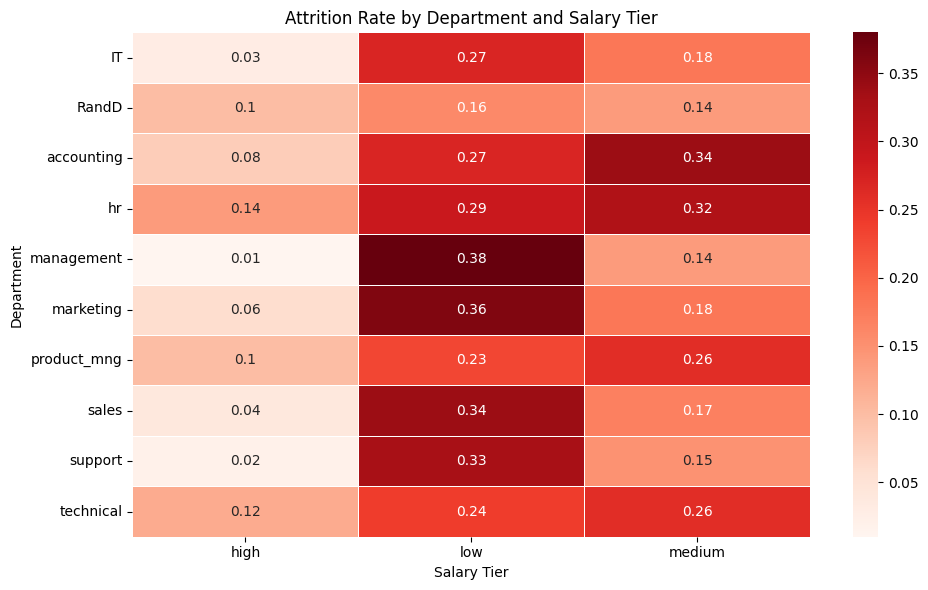

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume merged_df is already defined and available

# Step 1: Create Attrition Rate Table
attrition_table = (
    merged_df.groupby(['Department', 'salary'])['left']
    .mean()
    .unstack()
    .round(2)
)

# Step 2: Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(attrition_table, annot=True, cmap="Reds", linewidths=0.5)
plt.title("Attrition Rate by Department and Salary Tier")
plt.ylabel("Department")
plt.xlabel("Salary Tier")
plt.tight_layout()
plt.show()



#### 🧠 Key Observations:
- **Low-salary employees** in several departments show **elevated attrition rates**, especially in:
  - `Management` (38%)
  - `Marketing` (36%)
  - `Sales` (34%)
  - `Support` (33%)
- Medium-salary tiers also show notable risk in departments like:
  - `Accounting` (34%)
  - `HR` (32%)
- High-salary employees exhibit **consistently low attrition**, reinforcing the role of compensation in retention.

#### 📌 Implications for HR:
- **Targeted retention strategies** are needed in departments with red-hot zones (deep reds) — particularly among **lower-paid staff**.
- Consider reviewing:
  - Workload fairness
  - Recognition and promotion pipelines
  - Compensation benchmarking for low-salary brackets
- This heatmap provides a **data-driven focus** on where the organization is most vulnerable to losing talent.


### 9.4 Correlation Analysis

We explored correlations among numerical features using a correlation heatmap:

- **Satisfaction level** is **strongly negatively correlated** with attrition (`left`), with a correlation of **-0.38**, suggesting that dissatisfied employees are more likely to leave.
- Surprisingly, **last evaluation** and **average monthly hours** have weak correlations with attrition, indicating performance and hours alone don't drive turnover.
- There's also a mild **negative correlation** between **Work Accident** and **left**, hinting that those who've had accidents may be less likely to leave—possibly due to job security or accommodation factors.

These insights are useful for building predictive models or designing targeted interventions.

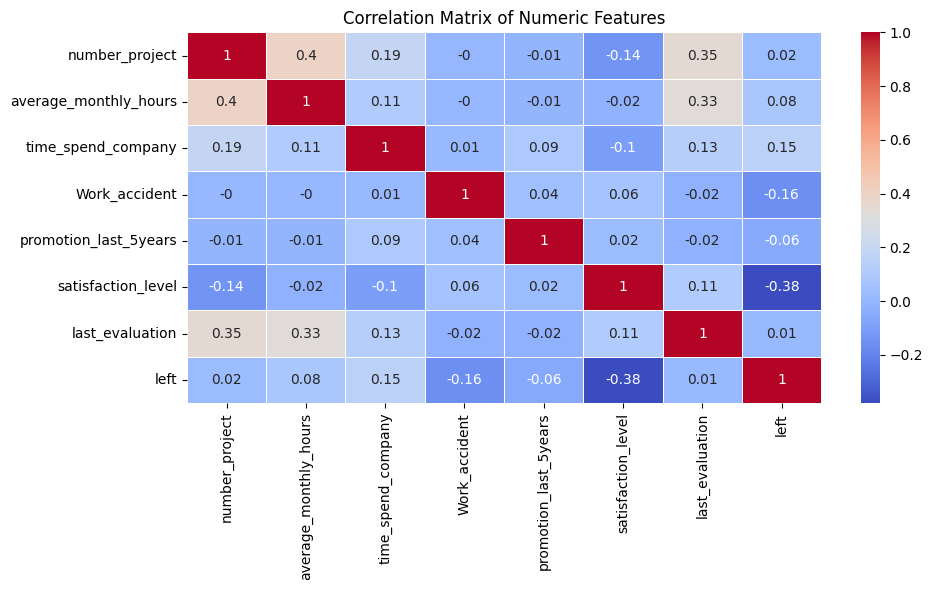

In [24]:
# Step 3: Correlation Analysis (numerical features only)
correlation_matrix = merged_df.corr(numeric_only=True).round(2)

# Step 4: Plot Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

#### 🧠 Key Insights:
- **Satisfaction level** is **strongly negatively correlated** with attrition (`left`, r = **–0.38**):
  - As satisfaction decreases, likelihood of leaving increases.
  - This makes it one of the most **predictive indicators** of employee attrition.

- **Work accident** has a **mild negative correlation** with attrition (r = **–0.16**):
  - Employees who experienced an accident may be less likely to leave, possibly due to **job protections or support policies**.

- Other features like:
  - **Last evaluation** (r ≈ 0.01)
  - **Average monthly hours** (r ≈ 0.08)
  - **Number of projects** (r ≈ 0.02)

  … show **weak or negligible correlation** with attrition, suggesting that performance metrics alone don’t strongly drive turnover decisions.

#### 📌 Implications:
- HR should prioritize **satisfaction tracking** as a proactive signal for potential exits.
- Low correlation with evaluation or workload metrics indicates the need to look beyond performance when addressing retention.

This matrix is especially useful for informing **predictive attrition models** or guiding **employee engagement strategies**.

### 📌 Conclusion

In this HR analytics project, we explored and combined data from two office branches and a centralized HR database to uncover key insights related to employee behavior, performance, and attrition risk. Our analysis covered:

- **Top Performers**: Identified departments with the highest workloads and spotlighted the top 10 employees based on average monthly hours.
- **Salary vs. Workload**: In some departments, high-salary employees reported fewer monthly hours than medium-salary peers—suggesting workload imbalances.
- **Attrition Risks**: Departments like *management* and *marketing* showed the highest attrition rates, particularly among low-salary staff.
- **Key Factors for Attrition**: Low satisfaction levels were strongly correlated with employee exits (`r = -0.38`). Additionally, fewer work accidents and longer company tenure were associated with higher attrition rates.
- **Employee Promotion Impact**: Interestingly, employees without promotions often had higher evaluation scores but lower satisfaction—pointing to potential retention issues.
- **Cross-Segment Comparison**: Pivot tables and grouped metrics helped reveal nuanced trends across tenure, department, and salary levels.

These findings can help HR departments identify high-risk segments, optimize workload distribution, and tailor retention strategies more effectively. Future work may include building predictive models to forecast attrition based on employee profiles.
